In [2]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
# models
from sklearn.ensemble import GradientBoostingClassifier
# design network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from matplotlib import pyplot

%matplotlib inline

In [3]:
train = pd.read_csv('gcTrianingSet.csv')

In [4]:
train['CUMSUM_cputime'] = train['cpuTimeTaken'].cumsum(axis = 0)

In [5]:
new = train[train['gcRun'] == True]

In [6]:
train.describe(include='all')

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,CUMSUM_cputime
count,2730.000000,2730.000000,2730,2730,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000
unique,NaN,NaN,91,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,token_41,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,30,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.775503,1.921919,NaN,NaN,0.415684,0.291495,0.479192,0.018359,0.000535,0.002755,0.186569,5.775588,1.921990,255.461629
std,0.801402,0.726219,NaN,NaN,1.619302,1.132280,1.855206,0.111837,0.007700,0.016707,0.128994,0.802645,0.728086,147.136479
min,4.129662,0.330214,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,4.117682,0.330214,0.371230
25%,5.143413,1.338731,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112348,5.137244,1.337994,128.070885
50%,5.758096,1.961032,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141588,5.758960,1.959821,255.542042
75%,6.418293,2.484630,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230622,6.419282,2.484630,383.730196


In [6]:
train['diff'] = train['finalUsedMemory'].values - train['initialUsedMemory'].values

In [7]:
train['freq'] = train['diff'].values / train['cpuTimeTaken'].values

In [9]:
train.describe(include='all')

,initialUsedMemory,initialFreeMemory,query token,gcRun,gcInitialMemory,gcFinalMemory,gcTotalMemory,userTime,sysTime,realTime,cpuTimeTaken,finalUsedMemory,finalFreeMemory,diff,freq
count,2730.000000,2730.000000,2730,2730,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000,2730.000000
unique,NaN,NaN,91,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,token_80,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,30,2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.775503,1.921919,NaN,NaN,0.415684,0.291495,0.479192,0.018359,0.000535,0.002755,0.186569,5.775588,1.921990,0.000085,-0.019479
std,0.801402,0.726219,NaN,NaN,1.619302,1.132280,1.855206,0.111837,0.007700,0.016707,0.128994,0.802645,0.728086,0.482923,2.876326
min,4.129662,0.330214,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001052,4.117682,0.330214,-2.575007,-24.433835
25%,5.143413,1.338731,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112348,5.137244,1.337994,0.054697,0.494437
50%,5.758096,1.961032,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141588,5.758960,1.959821,0.076620,0.560554
75%,6.418293,2.484630,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230622,6.419282,2.484630,0.133900,0.654622


In [10]:
train.columns

Index(['initialUsedMemory', 'initialFreeMemory', 'query token', 'gcRun',
       'gcInitialMemory', 'gcFinalMemory', 'gcTotalMemory', 'userTime',
       'sysTime', 'realTime', 'cpuTimeTaken', 'finalUsedMemory',
       'finalFreeMemory', 'diff', 'freq'],
      dtype='object')

In [11]:
data = train.drop(['gcInitialMemory', 'gcFinalMemory', 'gcTotalMemory', 'userTime', 'sysTime', 'realTime'], axis=1)

In [12]:
data.head()

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,diff,freq
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.160080,0.431215
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.072641,0.328867
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.060265,0.425069
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.073668,0.470844
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,0.170877,0.599111


In [13]:

newdata = data[data['gcRun'] == False]

small = newdata.groupby('query token', as_index=False)['freq'].mean()

In [15]:
result = data.merge(small, on='query token', right_index=True)

In [16]:
result = result.sort_index(axis=0)

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,diff,freq_x,freq_y
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.160080,0.431215,0.696677
102,4.873217,2.376295,token_1,False,0.193802,5.010445,2.239067,0.137228,0.708081,0.696677
259,5.490317,2.017495,token_1,False,0.196103,5.621264,1.886548,0.130947,0.667747,0.696677
274,4.509700,3.048405,token_1,False,0.191939,4.647537,2.910569,0.137836,0.718124,0.696677
394,5.181700,2.515077,token_1,False,0.191070,5.319710,2.377067,0.138010,0.722304,0.696677
457,4.353560,3.448198,token_1,False,0.191412,4.488307,3.313451,0.134747,0.703965,0.696677
564,6.607853,1.294491,token_1,True,0.188288,4.220680,3.693871,-2.387173,-12.678319,0.696677
637,4.516493,3.289659,token_1,False,0.191804,4.645598,3.160554,0.129105,0.673110,0.696677
766,5.027514,2.114088,token_1,False,0.191983,5.170535,1.971066,0.143021,0.744970,0.696677
886,6.408616,1.163650,token_1,True,0.195108,4.449746,3.117637,-1.958870,-10.039939,0.696677


In [18]:
ll = newdata.groupby('query token', as_index=False)['diff'].mean()

In [19]:
result = result.merge(ll, on='query token', right_index=True)

In [20]:
result.sort_index(axis=0)

,initialUsedMemory,initialFreeMemory,query token,gcRun,cpuTimeTaken,finalUsedMemory,finalFreeMemory,diff_x,freq_x,freq_y,diff_y
0,4.249634,2.999878,token_1,False,0.371230,4.409714,2.839798,0.160080,0.431215,0.696677,0.136833
1,4.409720,2.839792,token_2,False,0.220883,4.482361,2.767151,0.072641,0.328867,0.527402,0.062817
2,4.482361,2.767151,token_3,False,0.141776,4.542626,2.706886,0.060265,0.425069,0.477051,0.055497
3,4.542626,2.706886,token_4,False,0.156459,4.616293,2.633218,0.073668,0.470844,0.513401,0.066184
4,4.616296,2.633216,token_5,False,0.285218,4.787172,2.462339,0.170877,0.599111,0.638627,0.158079
5,4.787174,2.462337,token_6,False,0.170063,4.902623,2.346889,0.115449,0.678856,0.725251,0.106769
6,4.902623,2.346889,token_7,False,0.164785,4.977153,2.272359,0.074530,0.452285,0.486677,0.066470
7,4.977155,2.272357,token_8,True,0.154474,4.168083,3.081428,-0.809071,-5.237581,0.755169,0.098450
8,4.171586,3.077926,token_9,False,0.457611,4.520573,2.728938,0.348987,0.762630,0.744114,0.347700
9,4.523625,2.725887,token_10,False,0.182251,4.621179,2.628333,0.097554,0.535273,0.530135,0.096914


In [21]:
train_data = result.drop(['freq_x', 'diff_x'], axis=1)

In [22]:
freeusedmemory = train_data['finalUsedMemory']
finalfreememory = train_data['finalFreeMemory']
traindata = train_data.drop(['finalUsedMemory', 'finalFreeMemory'], axis=1)

In [23]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
traindata['query token'] = encoder.fit_transform(traindata['query token'].astype('str'))
traindata['gcRun'] = encoder.fit_transform(traindata['gcRun'].astype('str'))

In [24]:
traindata = traindata.sort_index(axis=0)
cols = traindata.columns

In [25]:
traindata = traindata.values

In [26]:
traindata

array([[  4.24963384e+00,   2.99987788e+00,   0.00000000e+00, ...,
          3.71230016e-01,   6.96677061e-01,   1.36833050e-01],
       [  4.40971984e+00,   2.83979188e+00,   1.10000000e+01, ...,
          2.20883048e-01,   5.27401691e-01,   6.28169937e-02],
       [  4.48236098e+00,   2.76715074e+00,   2.20000000e+01, ...,
          1.41776299e-01,   4.77051433e-01,   5.54966052e-02],
       ..., 
       [  6.66385527e+00,   1.03096895e+00,   6.00000000e+01, ...,
          1.09346554e-01,   5.49357766e-01,   6.00511422e-02],
       [  6.72796255e+00,   9.66861673e-01,   3.60000000e+01, ...,
          3.71937577e-01,   8.36047402e-01,   3.09897915e-01],
       [  7.03636777e+00,   6.58456445e-01,   6.40000000e+01, ...,
          1.15547996e-01,   6.27657014e-01,   6.95381181e-02]])

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas import DataFrame, concat
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(traindata)
# frame as supervised learning
reframed = series_to_supervised(traindata, 1, 1)
# drop columns we don't want to predict
reframed1 = reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1)
print(reframed1.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)   var1(t)  
1   0.136833  4.409720  
2   0.062817  4.482361  
3   0.055497  4.542626  
4   0.066184  4.616296  
5   0.158079  4.787174  


In [28]:
# split into train and test sets
values = reframed1.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 1, 7) (2000,) (729, 1, 7) (729,)


Train on 2000 samples, validate on 729 samples
Epoch 1/300
0s - loss: 5.2217 - val_loss: 5.3735
Epoch 2/300
0s - loss: 4.4091 - val_loss: 4.6809
Epoch 3/300
0s - loss: 3.7215 - val_loss: 3.5583
Epoch 4/300
0s - loss: 2.1868 - val_loss: 1.9337
Epoch 5/300
0s - loss: 1.0497 - val_loss: 1.0535
Epoch 6/300
0s - loss: 0.9319 - val_loss: 0.8765
Epoch 7/300
0s - loss: 0.9265 - val_loss: 0.8325
Epoch 8/300
0s - loss: 0.9472 - val_loss: 0.8292
Epoch 9/300
0s - loss: 0.9191 - val_loss: 0.8056
Epoch 10/300
0s - loss: 0.8926 - val_loss: 0.7713
Epoch 11/300
0s - loss: 0.9172 - val_loss: 0.7387
Epoch 12/300
0s - loss: 0.8819 - val_loss: 0.7332
Epoch 13/300
0s - loss: 0.9121 - val_loss: 0.7298
Epoch 14/300
0s - loss: 0.8439 - val_loss: 0.6789
Epoch 15/300
0s - loss: 0.8385 - val_loss: 0.6264
Epoch 16/300
0s - loss: 0.8466 - val_loss: 0.6194
Epoch 17/300
0s - loss: 0.8197 - val_loss: 0.5795
Epoch 18/300
0s - loss: 0.7866 - val_loss: 0.5405
Epoch 19/300
0s - loss: 0.7954 - val_loss: 0.5217
Epoch 20/300

0s - loss: 0.4298 - val_loss: 0.1125
Epoch 164/300
0s - loss: 0.4480 - val_loss: 0.1427
Epoch 165/300
0s - loss: 0.4286 - val_loss: 0.1060
Epoch 166/300
0s - loss: 0.4495 - val_loss: 0.1670
Epoch 167/300
0s - loss: 0.4457 - val_loss: 0.1087
Epoch 168/300
0s - loss: 0.4518 - val_loss: 0.1470
Epoch 169/300
0s - loss: 0.4511 - val_loss: 0.1252
Epoch 170/300
0s - loss: 0.4455 - val_loss: 0.1522
Epoch 171/300
0s - loss: 0.4503 - val_loss: 0.1119
Epoch 172/300
0s - loss: 0.4325 - val_loss: 0.1159
Epoch 173/300
0s - loss: 0.4466 - val_loss: 0.1822
Epoch 174/300
0s - loss: 0.4462 - val_loss: 0.1284
Epoch 175/300
0s - loss: 0.4251 - val_loss: 0.1492
Epoch 176/300
0s - loss: 0.4296 - val_loss: 0.1410
Epoch 177/300
0s - loss: 0.4307 - val_loss: 0.1102
Epoch 178/300
0s - loss: 0.4393 - val_loss: 0.1255
Epoch 179/300
0s - loss: 0.4416 - val_loss: 0.1187
Epoch 180/300
0s - loss: 0.4361 - val_loss: 0.1037
Epoch 181/300
0s - loss: 0.4191 - val_loss: 0.1113
Epoch 182/300
0s - loss: 0.4280 - val_loss: 0

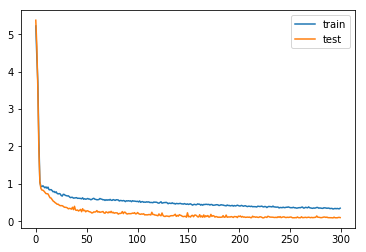

In [29]:
model1 = Sequential()
model1.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mae', optimizer='adam')
# fit network
history = model1.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
# make a prediction
yhat = model1.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.122


In [33]:
reframed2 = reframed.drop(reframed.columns[[9,10,11,12,13]], axis=1)
print(reframed2.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)   var1(t)   var2(t)  
1   0.136833  4.409720  2.839792  
2   0.062817  4.482361  2.767151  
3   0.055497  4.542626  2.706886  
4   0.066184  4.616296  2.633216  
5   0.158079  4.787174  2.462337  


In [34]:
# split into train and test sets
values = reframed2.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 1, 8) (2000,) (729, 1, 8) (729,)


Train on 2000 samples, validate on 729 samples
Epoch 1/300
0s - loss: 1.0200 - val_loss: 0.6365
Epoch 2/300
0s - loss: 0.8440 - val_loss: 0.6137
Epoch 3/300
0s - loss: 0.7297 - val_loss: 0.6360
Epoch 4/300
0s - loss: 0.6766 - val_loss: 0.6242
Epoch 5/300
0s - loss: 0.6612 - val_loss: 0.6203
Epoch 6/300
0s - loss: 0.6495 - val_loss: 0.6123
Epoch 7/300
0s - loss: 0.6313 - val_loss: 0.6052
Epoch 8/300
0s - loss: 0.6248 - val_loss: 0.5889
Epoch 9/300
0s - loss: 0.5894 - val_loss: 0.4770
Epoch 10/300
0s - loss: 0.5182 - val_loss: 0.3672
Epoch 11/300
0s - loss: 0.4831 - val_loss: 0.3427
Epoch 12/300
0s - loss: 0.4521 - val_loss: 0.3121
Epoch 13/300
0s - loss: 0.4170 - val_loss: 0.2803
Epoch 14/300
0s - loss: 0.3826 - val_loss: 0.2633
Epoch 15/300
0s - loss: 0.3627 - val_loss: 0.2333
Epoch 16/300
0s - loss: 0.3459 - val_loss: 0.2134
Epoch 17/300
0s - loss: 0.3428 - val_loss: 0.2127
Epoch 18/300
0s - loss: 0.3298 - val_loss: 0.1916
Epoch 19/300
0s - loss: 0.3295 - val_loss: 0.1711
Epoch 20/300

0s - loss: 0.1718 - val_loss: 0.0701
Epoch 164/300
0s - loss: 0.1717 - val_loss: 0.0768
Epoch 165/300
0s - loss: 0.1831 - val_loss: 0.0683
Epoch 166/300
0s - loss: 0.1692 - val_loss: 0.0706
Epoch 167/300
0s - loss: 0.1712 - val_loss: 0.0822
Epoch 168/300
0s - loss: 0.1730 - val_loss: 0.0731
Epoch 169/300
0s - loss: 0.1738 - val_loss: 0.0714
Epoch 170/300
0s - loss: 0.1709 - val_loss: 0.0758
Epoch 171/300
0s - loss: 0.1713 - val_loss: 0.0810
Epoch 172/300
0s - loss: 0.1631 - val_loss: 0.0807
Epoch 173/300
0s - loss: 0.1676 - val_loss: 0.0766
Epoch 174/300
0s - loss: 0.1691 - val_loss: 0.0714
Epoch 175/300
0s - loss: 0.1669 - val_loss: 0.0772
Epoch 176/300
0s - loss: 0.1666 - val_loss: 0.0705
Epoch 177/300
0s - loss: 0.1657 - val_loss: 0.0759
Epoch 178/300
0s - loss: 0.1640 - val_loss: 0.0639
Epoch 179/300
0s - loss: 0.1775 - val_loss: 0.0724
Epoch 180/300
0s - loss: 0.1679 - val_loss: 0.0711
Epoch 181/300
0s - loss: 0.1775 - val_loss: 0.0735
Epoch 182/300
0s - loss: 0.1657 - val_loss: 0

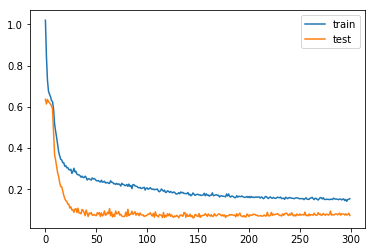

In [35]:
model2 = Sequential()
model2.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
yhat = model2.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.120


In [42]:
reframed3 = reframed.drop(reframed.columns[[7,8,9,11,12,13]], axis=1)
print(reframed3.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.249634   2.999878        0.0        0.0   0.371230   0.696677   
2   4.409720   2.839792       11.0        0.0   0.220883   0.527402   
3   4.482361   2.767151       22.0        0.0   0.141776   0.477051   
4   4.542626   2.706886       33.0        0.0   0.156459   0.513401   
5   4.616296   2.633216       44.0        0.0   0.285218   0.638627   

   var7(t-1)  var4(t)  
1   0.136833      0.0  
2   0.062817      0.0  
3   0.055497      0.0  
4   0.066184      0.0  
5   0.158079      0.0  


In [43]:
# split into train and test sets
n_train_hours = 2000
train = reframed3.iloc[:n_train_hours, :]
test = reframed3.iloc[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 7) (2000,) (729, 7) (729,)


training time:  0:00:00.178401
testing time:  0:00:00.001536
classification report: 
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97       688
        1.0       0.48      0.49      0.48        41

avg / total       0.94      0.94      0.94       729

f1 score
0.725327491785
accuracy score
0.941015089163
confusion matrix:
[[666  22]
 [ 21  20]]


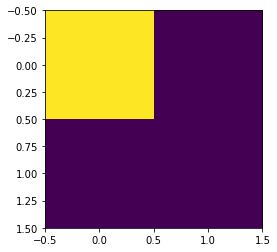

In [48]:
def testClassifier(x_train, y_train, x_test, y_test, clf):
    """
    this method will first train the classifier on the training data
    and will then test the trained classifier on test data.
    Finally it will report some metrics on the classifier performance.
    
    Parameters:
    
    x_train: (np.ndarray) train data matrix
    
    y_train: (list) train data label
    
    x_test: (np.ndarray) test data matrix
    
    y_test: (list) test data label
    
    clf: sklearn classifier object implementing fit() and predict() methods
    
    Returns:

    metrics: list
             [training time, testing time, recall and precision for every class, macro-averaged F1 score]
    """
    metrics = []
    start = dt.now()
    clf.fit(x_train, y_train)
    end = dt.now()
    print ('training time: ', (end - start))
    
    # add training time to metrics
    metrics.append(end-start)
    
    start = dt.now()
    pred = clf.predict(x_test)
    end = dt.now()
    print( 'testing time: ', (end - start))
    
    # add testing time to metrics
    metrics.append(end-start)
    
    print( 'classification report: ')
    # print classification_report(y_test, yhat)
    print (classification_report(y_test, pred))
    
    print ('f1 score')
    print (f1_score(y_test, pred, average='macro'))
    
    print ('accuracy score')
    print (accuracy_score(y_test, pred))
    
    precision = precision_score(y_test, pred, average=None)
    recall = recall_score(y_test, pred, average=None)
    
    # add precision and recall values to metrics
    for p, r in zip(precision, recall):
        metrics.append(p)
        metrics.append(r)
    
    
    #add macro-averaged F1 score to metrics
    metrics.append(f1_score(y_test, pred, average='macro'))
    
    print ('confusion matrix:')
    print (confusion_matrix(y_test, pred))
    
    # plotting the confusion matrix
    plt.imshow(confusion_matrix(y_test, pred), interpolation='nearest')
    plt.show()
    
    return metrics



gbm = GradientBoostingClassifier(n_estimators=40, learning_rate=0.1,
                                max_depth=5, random_state=0, subsample=0.8, max_features=0.8)

# If we tune we can get more accuracy
boost = testClassifier(train_X, train_y, test_X, test_y, gbm)

training time:  0:00:00.182533
testing time:  0:00:00.003595
classification report: 
             precision    recall  f1-score   support

        0.0       0.99      0.83      0.90       688
        1.0       0.24      0.90      0.38        41

avg / total       0.95      0.83      0.87       729

f1 score
0.641841768683
accuracy score
0.83401920439
confusion matrix:
[[571 117]
 [  4  37]]


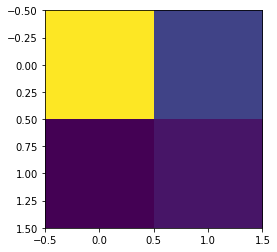

In [104]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate =0.1,
                     n_estimators=50,
                     max_depth=4,
                     min_child_weight=6,
                     gamma=0.1,
                     reg_alpha=0.01,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     objective= 'binary:logistic',
                     scale_pos_weight=8,
                     seed=27)
xgboost = testClassifier(train_X, train_y, test_X, test_y, xgb)

In [137]:
test = pd.read_csv('gcPredictionFile.csv')
#test['CUMSUM_cputime'] = test['cpuTimeTaken'].cumsum(axis = 0)
test = test.merge(small, on='query token', right_index=True)
test = test.sort_index()
test = test.merge(ll, on='query token', right_index=True)
test = test.sort_index()
test['query token'] = encoder.fit_transform(test['query token'].astype('str'))
test['gcRun'] = encoder.fit_transform(test['gcRun'].astype('str'))
test.loc[:,['gcRun','cpuTimeTaken']] = test.loc[:,['cpuTimeTaken','gcRun']].values
test.columns = cols

test['gcRun'][0] = 1
test['gcRun'][0]

/home/itachi/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


1.0

In [138]:
test.fillna(value=0, inplace=True)

In [139]:
test = series_to_supervised(test, 1, 1)
# drop columns we don't want to predict
test = test.drop(reframed.columns[[8,9,10,11,12,13]], axis=1)
print(test.head())
column = test.columns

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   4.247186   2.774299        2.0        1.0   0.408436   0.520126   
2   0.000000   0.000000       73.0        0.0   0.124429   0.522675   
3   0.000000   0.000000       48.0        0.0   0.245838   0.468081   
4   0.000000   0.000000       86.0        0.0   0.169346   0.674019   
5   0.000000   0.000000       67.0        0.0   0.296311   0.732314   

   var7(t-1)  var1(t)  
1   0.098823      0.0  
2   0.044418      0.0  
3   0.047545      0.0  
4   0.125974      0.0  
5   0.240021      0.0  


In [140]:
final = test.copy()

In [141]:
for i in range(test.shape[0]):
    gc = test['var4(t-1)'][i] = xgb.predict(test.iloc[i:i+1,:7])
    test = test.values
    test = test.reshape((test.shape[0], 1, test.shape[1]))
    ffm = test[i+1:i+2,:,0] = test[i:i+1,:,7:] = model1.predict(test[i:i+1,:,:7])
    fum = test[i+1:i+2,:,1] = model2.predict(test[i:i+1])
    test = test.reshape((test.shape[0], test.shape[2]))
    test = pd.DataFrame(test)
    test.columns = column
    print(gc, ffm, fum)

[ 0.] [[ 3.5836153]] [[ 3.48845387]]
[ 0.] [[ 4.47977066]] [[ 3.29340601]]
[ 0.] [[ 4.80966234]] [[ 3.07471275]]
[ 0.] [[ 5.09656239]] [[ 2.84313893]]
[ 0.] [[ 5.40188217]] [[ 2.54655504]]
[ 0.] [[ 5.32863045]] [[ 2.50224161]]
[ 0.] [[ 5.4665947]] [[ 2.41112423]]
[ 0.] [[ 5.68060207]] [[ 2.23359346]]
[ 0.] [[ 5.82052612]] [[ 2.12784696]]
[ 0.] [[ 5.8784852]] [[ 2.00846577]]
[ 0.] [[ 6.05766201]] [[ 1.7919457]]
[ 0.] [[ 6.18350792]] [[ 1.6745404]]
[ 0.] [[ 6.8057785]] [[ 0.97511631]]
[ 0.] [[ 6.83011055]] [[ 0.996086]]
[ 0.] [[ 6.99691868]] [[ 0.91961277]]
[ 1.] [[ 4.82819653]] [[ 2.92858505]]
[ 0.] [[ 5.23391819]] [[ 2.6683383]]
[ 0.] [[ 5.2122736]] [[ 2.50374961]]
[ 0.] [[ 5.37121725]] [[ 2.40819263]]
[ 0.] [[ 5.75603151]] [[ 2.09550905]]
[ 0.] [[ 5.92153072]] [[ 1.99858451]]
[ 0.] [[ 6.03078747]] [[ 1.90244246]]
[ 0.] [[ 6.11689472]] [[ 1.8066622]]
[ 0.] [[ 6.13123035]] [[ 1.69761765]]
[ 0.] [[ 6.10865021]] [[ 1.65958965]]
[ 0.] [[ 6.27952433]] [[ 1.56307709]]
[ 1.] [[ 4.44028664]] [

[ 0.] [[ 6.745718]] [[ 1.08183885]]
[ 0.] [[ 6.79040051]] [[ 1.00676465]]
[ 0.] [[ 6.87081432]] [[ 0.95275724]]
[ 1.] [[ 4.72327614]] [[ 2.87886667]]
[ 0.] [[ 5.11977577]] [[ 2.7696476]]
[ 0.] [[ 5.19371796]] [[ 2.57688808]]
[ 0.] [[ 5.46194124]] [[ 2.4633944]]
[ 0.] [[ 5.9598856]] [[ 1.8910042]]
[ 0.] [[ 6.2340045]] [[ 1.52166188]]
[ 1.] [[ 4.43374443]] [[ 3.35061502]]
[ 0.] [[ 4.67793608]] [[ 3.14718771]]
[ 0.] [[ 4.70727348]] [[ 3.00201797]]
[ 0.] [[ 4.81616879]] [[ 2.83527136]]
[ 0.] [[ 4.99158096]] [[ 2.74746656]]
[ 0.] [[ 5.29566669]] [[ 2.6160574]]
[ 0.] [[ 5.59089613]] [[ 2.34583426]]
[ 0.] [[ 5.54049301]] [[ 2.26909971]]
[ 0.] [[ 5.77644634]] [[ 2.12972832]]
[ 0.] [[ 5.79155302]] [[ 2.06207848]]
[ 0.] [[ 5.88857412]] [[ 1.88365448]]
[ 0.] [[ 6.29811954]] [[ 1.46515751]]
[ 1.] [[ 4.71697617]] [[ 3.19007659]]
[ 0.] [[ 4.98377228]] [[ 2.96776152]]
[ 0.] [[ 5.17286491]] [[ 2.80159521]]
[ 0.] [[ 5.39739132]] [[ 2.54859781]]
[ 0.] [[ 5.51172686]] [[ 2.46571684]]
[ 0.] [[ 5.63833761]

[ 0.] [[ 5.88683224]] [[ 2.05268621]]
[ 0.] [[ 5.90395355]] [[ 1.97663975]]
[ 0.] [[ 5.97498131]] [[ 1.88033366]]
[ 0.] [[ 5.92705297]] [[ 1.84901619]]
[ 0.] [[ 6.09698248]] [[ 1.78107142]]
[ 0.] [[ 6.34102154]] [[ 1.48224604]]
[ 0.] [[ 6.52192497]] [[ 1.29880321]]
[ 0.] [[ 6.91123009]] [[ 0.94105804]]
[ 1.] [[ 4.79258776]] [[ 2.94779587]]
[ 0.] [[ 5.12689209]] [[ 2.78637075]]
[ 0.] [[ 5.31573772]] [[ 2.65105653]]
[ 0.] [[ 5.45047998]] [[ 2.52953053]]
[ 0.] [[ 5.61911774]] [[ 2.32909775]]
[ 0.] [[ 5.78396368]] [[ 2.14718294]]
[ 0.] [[ 5.78295898]] [[ 2.00752735]]
[ 0.] [[ 5.96702814]] [[ 1.93467784]]
[ 0.] [[ 6.13752747]] [[ 1.74952435]]
[ 0.] [[ 6.2369132]] [[ 1.55937767]]
[ 0.] [[ 6.36922455]] [[ 1.46402311]]
[ 0.] [[ 6.4536438]] [[ 1.35849977]]
[ 0.] [[ 6.62633991]] [[ 1.18886805]]
[ 0.] [[ 6.67114353]] [[ 1.14240682]]
[ 0.] [[ 6.72719765]] [[ 1.0559324]]
[ 0.] [[ 6.75889158]] [[ 1.0364939]]
[ 0.] [[ 6.80918598]] [[ 1.00988984]]
[ 0.] [[ 6.85660744]] [[ 0.98909575]]
[ 0.] [[ 6.85259

[ 1.] [[ 5.23281765]] [[ 2.75581789]]
[ 0.] [[ 5.35605526]] [[ 2.60752916]]
[ 0.] [[ 5.47024441]] [[ 2.48949814]]
[ 0.] [[ 5.40308857]] [[ 2.40180302]]
[ 0.] [[ 5.74744749]] [[ 2.14704609]]
[ 0.] [[ 5.82745838]] [[ 2.07648969]]
[ 0.] [[ 5.82504082]] [[ 2.06210017]]
[ 0.] [[ 5.92298126]] [[ 1.88023758]]
[ 0.] [[ 6.0847702]] [[ 1.7914629]]
[ 0.] [[ 6.11087894]] [[ 1.71487749]]
[ 0.] [[ 6.25006485]] [[ 1.61308885]]
[ 0.] [[ 6.34966755]] [[ 1.45082736]]
[ 0.] [[ 6.46822929]] [[ 1.34486687]]
[ 0.] [[ 6.52109241]] [[ 1.25365973]]
[ 0.] [[ 6.62716627]] [[ 1.18634033]]
[ 0.] [[ 6.69854259]] [[ 1.14120102]]
[ 1.] [[ 4.71870041]] [[ 3.03209424]]
[ 0.] [[ 5.02403402]] [[ 2.88413811]]
[ 0.] [[ 5.24170065]] [[ 2.71986175]]
[ 0.] [[ 5.29854822]] [[ 2.56974459]]
[ 0.] [[ 5.32470465]] [[ 2.4901371]]
[ 0.] [[ 5.29486084]] [[ 2.39053988]]
[ 0.] [[ 5.54923916]] [[ 2.33793974]]
[ 0.] [[ 5.64161825]] [[ 2.30375624]]
[ 0.] [[ 5.59512711]] [[ 2.23795223]]
[ 0.] [[ 5.71635818]] [[ 2.09716249]]
[ 0.] [[ 5.8585

[ 0.] [[ 6.03691959]] [[ 1.80102706]]
[ 0.] [[ 6.23672533]] [[ 1.56931114]]
[ 0.] [[ 6.40058994]] [[ 1.42394114]]
[ 0.] [[ 6.47443008]] [[ 1.33849192]]
[ 0.] [[ 6.56348133]] [[ 1.2729497]]
[ 0.] [[ 6.60950994]] [[ 1.17854536]]
[ 0.] [[ 6.69027519]] [[ 1.13136995]]
[ 0.] [[ 7.04394531]] [[ 0.89095151]]
[ 1.] [[ 5.00907803]] [[ 2.88193607]]
[ 0.] [[ 5.22436571]] [[ 2.73583841]]
[ 0.] [[ 5.27041578]] [[ 2.55630207]]
[ 0.] [[ 5.4709754]] [[ 2.46540833]]
[ 0.] [[ 6.18060684]] [[ 1.56756234]]
[ 0.] [[ 6.33820295]] [[ 1.49107254]]
[ 1.] [[ 4.44380474]] [[ 3.16918373]]
[ 0.] [[ 4.49253702]] [[ 3.06675816]]
[ 0.] [[ 4.93494225]] [[ 2.91415548]]
[ 0.] [[ 5.17519665]] [[ 2.77398014]]
[ 0.] [[ 5.58440876]] [[ 2.33198738]]
[ 0.] [[ 5.66483641]] [[ 2.25065327]]
[ 0.] [[ 5.72353363]] [[ 2.15858984]]
[ 0.] [[ 5.77296352]] [[ 2.08299446]]
[ 0.] [[ 5.86277866]] [[ 1.97984076]]
[ 0.] [[ 5.98361683]] [[ 1.83186197]]
[ 0.] [[ 6.20985699]] [[ 1.63992012]]
[ 0.] [[ 6.30144882]] [[ 1.55541933]]
[ 0.] [[ 6.392

[ 0.] [[ 5.65672493]] [[ 2.14072561]]
[ 0.] [[ 5.77373028]] [[ 2.05639315]]
[ 0.] [[ 5.94562101]] [[ 1.96249652]]
[ 0.] [[ 6.05491352]] [[ 1.86979127]]
[ 0.] [[ 6.0832634]] [[ 1.78198218]]
[ 0.] [[ 6.10391235]] [[ 1.76205492]]
[ 0.] [[ 6.21516085]] [[ 1.6413033]]
[ 0.] [[ 6.32113266]] [[ 1.50893247]]
[ 0.] [[ 6.33679676]] [[ 1.47374594]]
[ 0.] [[ 6.4398303]] [[ 1.38118255]]
[ 0.] [[ 6.52571201]] [[ 1.2399224]]
[ 0.] [[ 6.64520741]] [[ 1.17178833]]
[ 0.] [[ 6.76612186]] [[ 1.06188941]]
[ 0.] [[ 7.09615612]] [[ 0.87927359]]
[ 1.] [[ 5.04103374]] [[ 2.80028629]]
[ 0.] [[ 5.03981972]] [[ 2.70772743]]
[ 0.] [[ 5.22925282]] [[ 2.60822392]]
[ 0.] [[ 5.49354458]] [[ 2.41414523]]
[ 0.] [[ 5.54770947]] [[ 2.22881317]]
[ 0.] [[ 5.80226994]] [[ 2.0928812]]
[ 0.] [[ 5.8113451]] [[ 2.0258522]]
[ 0.] [[ 5.86913157]] [[ 1.93233061]]
[ 0.] [[ 6.02753067]] [[ 1.83110499]]
[ 0.] [[ 6.13169813]] [[ 1.74606931]]
[ 0.] [[ 6.23769474]] [[ 1.65115607]]
[ 0.] [[ 6.1866703]] [[ 1.60289645]]
[ 0.] [[ 6.33656979]

[ 0.] [[ 6.45013142]] [[ 1.31161785]]
[ 0.] [[ 6.57163715]] [[ 1.24117863]]
[ 0.] [[ 6.6951685]] [[ 1.12370884]]
[ 0.] [[ 6.7591691]] [[ 1.08386958]]
[ 0.] [[ 6.8062644]] [[ 1.04473341]]
[ 0.] [[ 6.81722307]] [[ 1.02052534]]
[ 0.] [[ 6.8811264]] [[ 0.96792096]]
[ 0.] [[ 6.85456944]] [[ 0.96955621]]
[ 0.] [[ 6.9034462]] [[ 0.96204841]]
[ 1.] [[ 5.0147562]] [[ 2.85768008]]
[ 0.] [[ 5.833395]] [[ 1.93188429]]
[ 0.] [[ 5.98690081]] [[ 1.86732388]]
[ 0.] [[ 6.05602455]] [[ 1.78560257]]
[ 0.] [[ 6.18775272]] [[ 1.66310823]]
[ 0.] [[ 6.27445602]] [[ 1.58031452]]
[ 0.] [[ 6.35248947]] [[ 1.50030339]]
[ 0.] [[ 6.44235611]] [[ 1.40788591]]
[ 0.] [[ 6.51302958]] [[ 1.26121545]]
[ 1.] [[ 4.91182613]] [[ 2.95896864]]
[ 0.] [[ 5.40677643]] [[ 2.49235678]]
[ 0.] [[ 5.65656567]] [[ 2.27643108]]
[ 0.] [[ 5.7120676]] [[ 2.24078846]]
[ 0.] [[ 5.77101326]] [[ 2.14798403]]
[ 0.] [[ 5.89457035]] [[ 2.04208612]]
[ 0.] [[ 5.96271992]] [[ 1.88611174]]
[ 0.] [[ 6.00263834]] [[ 1.81709051]]
[ 0.] [[ 6.14657307]]

[ 0.] [[ 5.52551174]] [[ 2.42316318]]
[ 0.] [[ 5.69864225]] [[ 2.23318577]]
[ 0.] [[ 5.8366642]] [[ 2.06510925]]
[ 0.] [[ 5.92326355]] [[ 1.91446471]]
[ 0.] [[ 6.0596199]] [[ 1.8421644]]
[ 0.] [[ 6.20018482]] [[ 1.66550112]]
[ 0.] [[ 6.22702217]] [[ 1.5100081]]
[ 0.] [[ 6.39876509]] [[ 1.40544295]]
[ 0.] [[ 6.51928616]] [[ 1.26740551]]
[ 0.] [[ 6.6128664]] [[ 1.15586555]]
[ 0.] [[ 6.70151615]] [[ 1.12293041]]
[ 1.] [[ 4.88802814]] [[ 2.98341942]]
[ 0.] [[ 5.1682663]] [[ 2.76746774]]
[ 0.] [[ 5.35235548]] [[ 2.61020708]]
[ 0.] [[ 5.48647881]] [[ 2.49145269]]
[ 0.] [[ 5.59399843]] [[ 2.3681345]]
[ 0.] [[ 5.63815403]] [[ 2.28660297]]
[ 0.] [[ 5.68918657]] [[ 2.10175443]]
[ 0.] [[ 5.76286316]] [[ 1.97614503]]
[ 0.] [[ 5.96773052]] [[ 1.8955493]]
[ 0.] [[ 6.0157299]] [[ 1.79390001]]
[ 0.] [[ 6.1696434]] [[ 1.67779708]]
[ 0.] [[ 6.29124451]] [[ 1.56841028]]
[ 1.] [[ 4.66468143]] [[ 3.22465467]]
[ 0.] [[ 4.74752235]] [[ 3.03778315]]
[ 0.] [[ 4.95094967]] [[ 2.88476801]]
[ 0.] [[ 5.22322083]] 

In [142]:
test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,4.247186,2.774299,2.0,1.0,0.408436,0.520126,0.098823,3.583615
1,3.583615,3.488454,73.0,0.0,0.124429,0.522675,0.044418,4.479771
2,4.479771,3.293406,48.0,0.0,0.245838,0.468081,0.047545,4.809662
3,4.809662,3.074713,86.0,0.0,0.169346,0.674019,0.125974,5.096562
4,5.096562,2.843139,67.0,0.0,0.296311,0.732314,0.240021,5.401882
5,5.401882,2.546555,18.0,0.0,0.025018,0.497912,0.013522,5.328630
6,5.328630,2.502242,33.0,0.0,0.121191,0.513401,0.066184,5.466595
7,5.466595,2.411124,43.0,0.0,0.220577,0.660618,0.150208,5.680602
8,5.680602,2.233593,72.0,0.0,0.133468,0.526436,0.077532,5.820526
9,5.820526,2.127847,24.0,0.0,0.151191,0.578549,0.095986,5.878485


In [143]:
initialFreeMemory = test['var2(t-1)'].copy()
gcRun = test['var4(t-1)'].copy()

In [144]:
gcRun[13] == 1

False

In [145]:
for i in range(1624):
    if gcRun[i] == 1:
        gcRun[i] = 'True'
    else:
        gcRun[i] = 'False'
        

In [146]:
sample_submission = pd.DataFrame({
        "serialNum": range(1,1625),
        "initialFreeMemory": initialFreeMemory,
        "gcRun": gcRun
    })

In [147]:
sample_submission = sample_submission[['serialNum', 'initialFreeMemory', 'gcRun']]
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,True
1,2,3.488454,False
2,3,3.293406,False
3,4,3.074713,False
4,5,2.843139,False
5,6,2.546555,False
6,7,2.502242,False
7,8,2.411124,False
8,9,2.233593,False
9,10,2.127847,False


In [148]:
df = DataFrame(columns=('serialNum', 'initialFreeMemory', 'gcRun'))
df.loc[1624] = [1625, 0.9525423, False]
df

,serialNum,initialFreeMemory,gcRun
1624,1625,0.952542,False


In [149]:
sample_submission = pd.concat([sample_submission,df], axis=0)
sample_submission

,serialNum,initialFreeMemory,gcRun
0,1,2.774299,True
1,2,3.488454,False
2,3,3.293406,False
3,4,3.074713,False
4,5,2.843139,False
5,6,2.546555,False
6,7,2.502242,False
7,8,2.411124,False
8,9,2.233593,False
9,10,2.127847,False


In [150]:
sample_submission.to_csv('sample_submission.csv', index=False)